<a href="https://colab.research.google.com/github/Darknight899/Final_Lab1/blob/main/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Predict Housing Prices Using Linear and Polynomial Regression

## This lab compares linear and polynomial regression methods based off Indian housing price (in rupees). Many variables were observed within the dataset inlcuding the target variable 'Price (in rupees)', however, based on intuition on what drives housing prices, most independent variables were removed excluding 'Bathroom', 'Carpet Area', and 'Balcony'. Based on the dataset, can we predict, using linear and polynomial regression, India's housing price based off the variables evaluated.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Loading the data
df = pd.read_excel("house_prices.xlsx")
df.head(2)

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,...,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,...,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,...,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN


In [ ]:
# Rows and columns
print(df.shape)

(187531, 21)


In [ ]:
# Check missing values
print(df.isnull().sum())

Index                     0
Title                     0
Description            3023
Amount(in rupees)         0
Price (in rupees)     17665
location                  0
Carpet Area           80673
Status                  615
Floor                  7077
Transaction              83
Furnishing             2897
facing                70233
overlooking           81436
Society              109678
Bathroom                828
Balcony               48935
Car Parking          103357
Ownership             65517
Super Area           107685
Dimensions           187531
Plot Area            187531
dtype: int64


In [ ]:
# Dropping unwanted columns & checking data types
df.drop(['Index', 'location', 'facing', 'Furnishing', 'overlooking', 'Car Parking', 'Transaction', 'Society', 'Amount(in rupees)', 'Title', 'Super Area', 'Description', 'Ownership', 'Floor', 'Dimensions', 'Plot Area', 'Status'], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price (in rupees)  169866 non-null  float64
 1   Carpet Area        106858 non-null  object 
 2   Bathroom           186703 non-null  object 
 3   Balcony            138596 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.7+ MB


In [ ]:
# Fill in missing values and encode categorical variables to integers
df['Carpet Area'] = df['Carpet Area'].str.extract('(\d+)').astype(float)
numerical_features = ['Price (in rupees)', 'Carpet Area']
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

# Fill missing 'Bathroom' and 'Balcony' with mode=2
df['Bathroom'] = pd.to_numeric(df['Bathroom'], errors='coerce').fillna(2).astype(int)
df['Balcony'] = pd.to_numeric(df['Balcony'], errors='coerce').fillna(2).astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price (in rupees)  187531 non-null  float64
 1   Carpet Area        187531 non-null  float64
 2   Bathroom           187531 non-null  int64  
 3   Balcony            187531 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 5.7 MB


In [ ]:
# Double-check missing values
print(df.isnull().sum())

Price (in rupees)    0
Carpet Area          0
Bathroom             0
Balcony              0
dtype: int64


In [ ]:
# Descriptive statistics
df.describe()

,Price (in rupees),Carpet Area,Bathroom,Balcony
count,1.875310e+05,187531.000000,187531.000000,187531.000000
mean,7.437787e+03,1113.846319,2.424676,2.000261
std,2.593087e+04,2301.577804,0.861739,0.817864
min,0.000000e+00,1.000000,1.000000,1.000000
25%,4.501500e+03,960.000000,2.000000,1.000000
50%,6.034000e+03,1000.000000,2.000000,2.000000
75%,8.452500e+03,1136.000000,3.000000,2.000000
max,6.700000e+06,709222.000000,10.000000,10.000000


In [ ]:
# Cap outliers
df['Carpet Area'] = df['Carpet Area'].clip(upper=df['Carpet Area'].quantile(0.99))
df['Price (in rupees)'] = df['Price (in rupees)'].clip(upper=df['Price (in rupees)'].quantile(0.99))

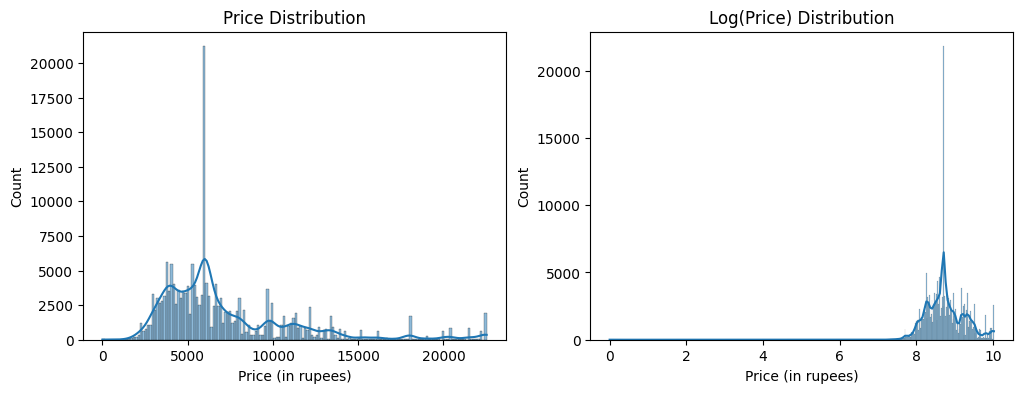

In [ ]:
# EDA -- Visualize distribution of Price (in rupees)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Price (in rupees)'], kde=True)
plt.title('Price Distribution')
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['Price (in rupees)']), kde=True)
plt.title('Log(Price) Distribution')
plt.show()

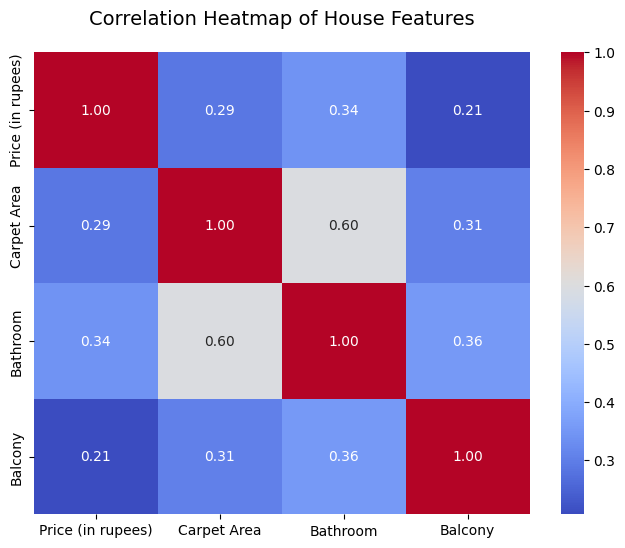

In [ ]:
# EDA -- Observe correlations
corr = df.corr()
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of House Features", pad=20, fontsize=14)
plt.show()

In [ ]:
# Print out correlation values
df.corr()[['Price (in rupees)']].sort_values(by='Price (in rupees)', ascending=False)

,Price (in rupees)
Price (in rupees),1.000000
Bathroom,0.341774
Carpet Area,0.287931
Balcony,0.207749


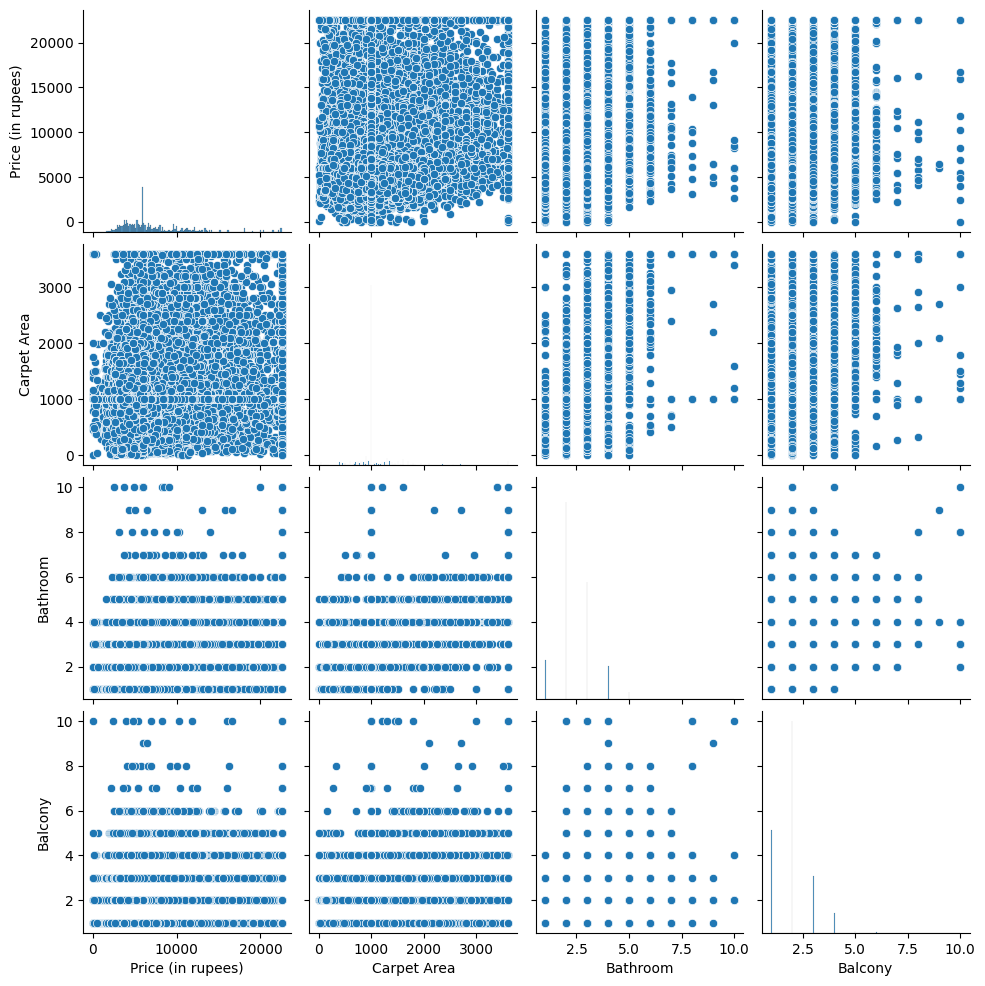

In [ ]:
# Check for linear relationships
sns.pairplot(df[['Price (in rupees)', 'Carpet Area', 'Bathroom', 'Balcony']])
plt.show()

In [ ]:
# Using bathroom as independent variable in linear regression (strongest correlation)
X = df[['Bathroom']]
y = df['Price (in rupees)']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
# Predict
y_pred = model.predict(X_test_scaled)
# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f}")

MSE: 14535455.04 | RMSE: 3812.54


In [ ]:
# Using Polynimal Regression with all independent variables
X = df[['Carpet Area', 'Balcony']]
y = df['Price (in rupees)']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [ ]:
# Polynimal Regression
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly_scaled, y_train)

LinearRegression()

In [ ]:
# Predict and evaluate
y_pred = poly_reg.predict(X_test_poly_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("\nPolynomial Regression Results:")
print("----------------------------")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")


Polynomial Regression Results:
----------------------------
MSE:  13,908,541.43
RMSE: 3,729.42


In [ ]:
## The polynomial regression model showed minimal improvement versus the linear regression model. Based off the results, it's evident that both models can be significantly improved. Perhaps incorporating location and other categorical variables would improve the accuracy of the models. The data exploration suggests that the dataset's variables have a non-linear relationship with 'Price (in rupees)'.

In [ ]:
## No References